# Create your Vision Chat Assistant with LLaVA

This Colab notebook accompanies the blog post [Create your Vision Chat Assistant with LLaVA](https://medium.com/p/610b02c3283e).

In [1]:
import json
json_path = "../scraper/output/output.json"

try:
    # Read the JSON file
    with open(json_path, "r") as file:
        data = json.load(file)

    # Print the first entry in the JSON data
    print(data[0])
    
except Exception as e:
    print(str(e))

{'src': 'http://mcz.edu.pl/Content/uploaded/images/Akredytacje%20WZ%20UW/EFMD-Global-EQUIS-Accredited-White%20mini%20na%20dole.png', 'alt': '', 'attrs': {'alt': '', 'class': ['img-responsive'], 'src': '/Content/uploaded/images/Akredytacje%20WZ%20UW/EFMD-Global-EQUIS-Accredited-White%20mini%20na%20dole.png'}, 'a_button_parent': 'None', 'previous_texts': ['h2: AI 4 Executives', 'h2: Rekrutacja', 'h2: Executive MBA po polsku', 'h2: Executive MBA po angielsku', 'h3: Aktualności'], 'previous_texts_cutoff_by_image_index': 1, 'next_texts': ['p: Międzynarodowe Centrum Zarządzania\nWydział Zarządzania\nUniwersytet Warszawski', 'p: ul. Szturmowa 1/3\n02-678 Warszawa\ntel.: 22\xa055 34 174\ntel.: 22 55 34 106\ne-mail: mba@uw.edu.pl', 'p: \xa0 ', 'p: © MCZ WZ UW 2013-2020', 'p: Powered by bluebirdCMS.Net      | Klauzula informacyjna\n'], 'next_texts_cutoff_by_image_index': 3}


## Install and import dependencies

In [2]:
# Install llava from the GitHub repository
%pip uninstall -y llava
%pip install git+https://github.com/haotian-liu/LLaVA.git@786aa6a19ea10edc6f574ad2e16276974e9aaa3a

Found existing installation: llava 1.1.3
Uninstalling llava-1.1.3:
  Successfully uninstalled llava-1.1.3
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/haotian-liu/LLaVA.git (to revision 786aa6a19ea10edc6f574ad2e16276974e9aaa3a) to /tmp/pip-req-build-382w123n
  Running command git clone --filter=blob:none --quiet https://github.com/haotian-liu/LLaVA.git /tmp/pip-req-build-382w123n
  Running command git rev-parse -q --verify 'sha^786aa6a19ea10edc6f574ad2e16276974e9aaa3a'
  Running command git fetch -q https://github.com/haotian-liu/LLaVA.git 786aa6a19ea10edc6f574ad2e16276974e9aaa3a
  Running command git checkout -q 786aa6a19ea10edc6f574ad2e16276974e9aaa3a
  Resolved https://github.com/haotian-liu/LLaVA.git to commit 786aa6a19ea10edc6f574ad2e16276974e9aaa3a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached transformers-4.31.0-py3-none-any.wh

In [3]:
from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, KeywordsStoppingCriteria
from llava.conversation import conv_templates, SeparatorStyle
import torch
from PIL import Image
import requests
from io import BytesIO

## Define the chatbot class


In [4]:
class LLaVAChatBot:
    def __init__(self,
                 model_path: str = 'liuhaotian/llava-v1.5-7b',
                 device_map: str = 'auto',
                 load_in_8_bit: bool = True,
                 **quant_kwargs) -> None:
        self.model = None
        self.tokenizer = None
        self.image_processor = None
        self.conv = None
        self.conv_img = None
        self.img_tensor = None
        self.roles = None
        self.stop_key = None
        self.load_models(model_path,
                         device_map=device_map,
                         load_in_8_bit=load_in_8_bit,
                         **quant_kwargs)

    def load_models(self, model_path: str,
                    device_map: str,
                    load_in_8_bit: bool,
                    **quant_kwargs) -> None:
        """Load the model, processor and tokenizer."""
        quant_cfg = BitsAndBytesConfig(**quant_kwargs)
        self.model = LlavaLlamaForCausalLM.from_pretrained(model_path,
                                                           low_cpu_mem_usage=True,
                                                           device_map=device_map,
                                                           load_in_8bit=load_in_8_bit,
                                                           quantization_config=quant_cfg)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path,
                                                       use_fast=False)
        vision_tower = self.model.get_vision_tower()
        vision_tower.load_model()
        vision_tower.to(device='cuda')
        self.image_processor = vision_tower.image_processor
        disable_torch_init()

    def setup_image(self, img_path: str) -> None:
        """Load and process the image."""
        if img_path.startswith('http') or img_path.startswith('https'):
            response = requests.get(img_path)
            self.conv_img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            self.conv_img = Image.open(img_path).convert('RGB')
        self.img_tensor = self.image_processor.preprocess(self.conv_img,
                                                          return_tensors='pt'
                                                          )['pixel_values'].half().cuda()

    def generate_answer(self, **kwargs) -> str:
        """Generate an answer from the current conversation."""
        raw_prompt = self.conv.get_prompt()
        input_ids = tokenizer_image_token(raw_prompt,
                                          self.tokenizer,
                                          IMAGE_TOKEN_INDEX,
                                          return_tensors='pt').unsqueeze(0).cuda()
        stopping = KeywordsStoppingCriteria([self.stop_key],
                                            self.tokenizer,
                                            input_ids)
        with torch.inference_mode():
            output_ids = self.model.generate(input_ids,
                                             images=self.img_tensor,
                                             stopping_criteria=[stopping],
                                             **kwargs)
        outputs = self.tokenizer.decode(
            output_ids[0, input_ids.shape[1]:]
        ).strip()
        self.conv.messages[-1][-1] = outputs

        return outputs.rsplit('</s>', 1)[0]

    def get_conv_text(self) -> str:
        """Return full conversation text."""
        return self.conv.get_prompt()

    def start_new_chat(self,
                       img_path: str,
                       prompt: str,
                       do_sample=True,
                       temperature=0.2,
                       max_new_tokens=1024,
                       use_cache=True,
                       **kwargs) -> str:
        """Start a new chat with a new image."""
        conv_mode = "v1"
        self.setup_image(img_path)
        self.conv = conv_templates[conv_mode].copy()
        self.roles = self.conv.roles
        first_input = (DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN +
                       DEFAULT_IM_END_TOKEN + '\n' + prompt)
        self.conv.append_message(self.roles[0], first_input)
        self.conv.append_message(self.roles[1], None)
        if self.conv.sep_style == SeparatorStyle.TWO:
            self.stop_key = self.conv.sep2
        else:
            self.stop_key = self.conv.sep
        answer = self.generate_answer(do_sample=do_sample,
                                      temperature=temperature,
                                      max_new_tokens=max_new_tokens,
                                      use_cache=use_cache,
                                      **kwargs)
        return answer

    def continue_chat(self,
                      prompt: str,
                      do_sample=True,
                      temperature=0.2,
                      max_new_tokens=1024,
                      use_cache=True,
                      **kwargs) -> str:
        """Continue the existing chat."""
        if self.conv is None:
            raise RuntimeError("No existing conversation found. Start a new"
                               "conversation using the `start_new_chat` method.")
        self.conv.append_message(self.roles[0], prompt)
        self.conv.append_message(self.roles[1], None)
        answer = self.generate_answer(do_sample=do_sample,
                                      temperature=temperature,
                                      max_new_tokens=max_new_tokens,
                                      use_cache=use_cache,
                                      **kwargs)
        return answer

## Setup the model

Download the model and set up the chatbot. It may take several minutes.

In [5]:
chatbot = LLaVAChatBot(load_in_8bit=True,
                       bnb_8bit_compute_dtype=torch.float16,
                       bnb_8bit_use_double_quant=True,
                       bnb_8bit_quant_type='nf8')

/home/felinejtd/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Begin evaluation

In [6]:
# Shuffle the data
import random
random.shuffle(data)

In [7]:
number_of_images = 100

prev_text_evals = [0, 0, 0, 0, 0]
next_text_evals = [0, 0, 0, 0, 0]

for image in data[0:number_of_images]:
    try:
        ans = chatbot.start_new_chat(img_path=image["src"],
                                prompt="Is this text relevant to the image? Only answer yes or no. Text: " + image["previous_texts"][0])
        prev_text_evals[0] += 1 if ans.lower() == "yes" else 0
        for i in range(1, len(image["previous_texts"])):
            ans = chatbot.continue_chat(prompt="Is this text relevant to the image? Only answer yes or no. Text: " + image["previous_texts"][i])
            prev_text_evals[i] += 1 if ans.lower() == "yes" else 0
        for i in range(len(image["next_texts"])):
            ans = chatbot.continue_chat(prompt="Is this text relevant to the image? Only answer yes or no. Text: " + image["next_texts"][i])
            next_text_evals[i] += 1 if ans.lower() == "yes" else 0
    except Exception as e:
        print(str(e))

print("Previous text evaluations:")
print(prev_text_evals)
print("Next text evaluations:")
print(next_text_evals)

mean must have 1 elements if it is an iterable, got 3


KeyboardInterrupt: 

In [44]:
print("Previous text evaluations:")
print(prev_text_evals)
print("Next text evaluations:")
print(next_text_evals)

Previous text evaluations:
[4, 2, 1, 2, 2]
Next text evaluations:
[3, 2, 2, 1, 0]


## Chat with the model

Example photo by Arnold Middelkoop on Unsplash.

In [8]:
ans = chatbot.start_new_chat(img_path="https://images.unsplash.com/photo-1686577353812-6cbc7fce384b?q=80&w=1887&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
                             prompt="Would the fish depicted in the image float if thrown in water? Think step by step.")

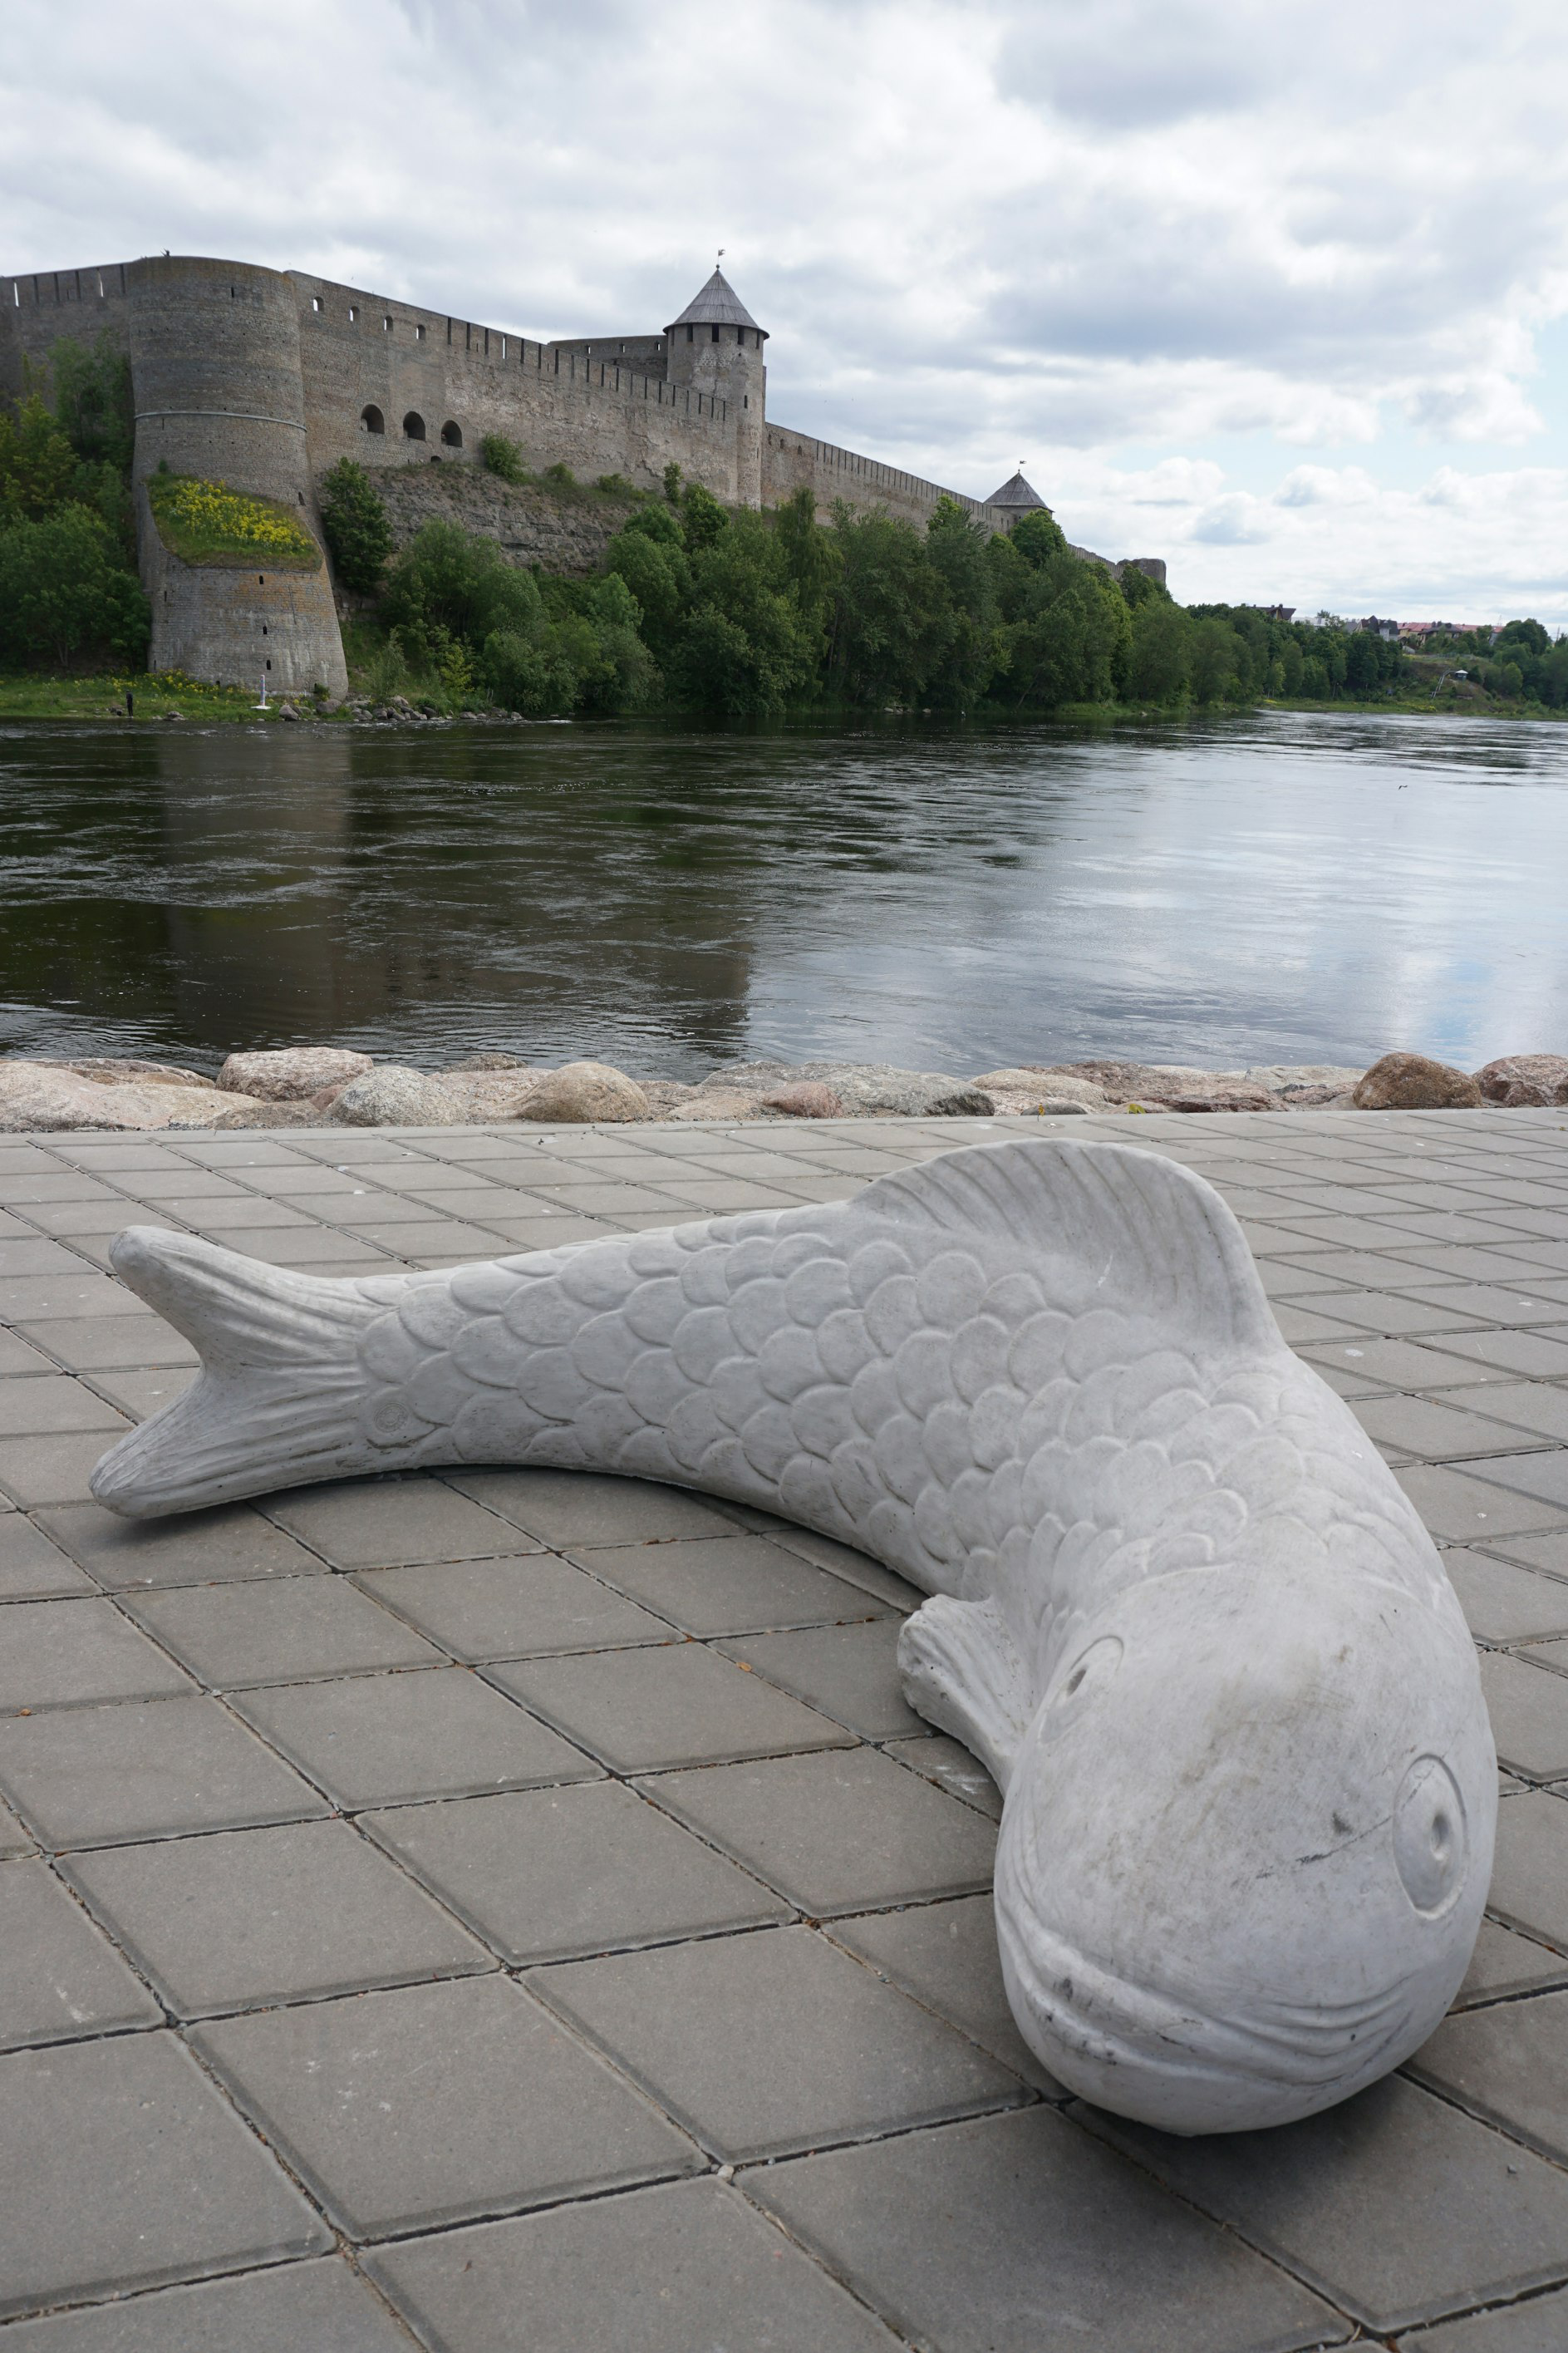

In [9]:
display(chatbot.conv_img)

In [10]:
print(ans)

The fish in the image is a large, white, and fake fish statue, which is lying on the ground near a body of water. If it were thrown into the water, it would not float as it is a statue and not a living creature. The statue's weight and material would make it sink to the bottom of the water, and it would not be able to float or swim like a real fish.


In [11]:
ans = chatbot.continue_chat("What material could be used to make a fish sculpture that floats on water?")

In [12]:
print(ans)

To make a fish sculpture that floats on water, one could use materials such as lightweight, buoyant foam or a combination of lightweight materials like styrofoam or expanded polystyrene beads, which are commonly used in floatation devices. These materials would provide the necessary buoyancy to keep the fish sculpture afloat in the water. Additionally, the sculpture could be painted or coated with a water-resistant material to protect it from the elements and prolong its lifespan.


Get the full conversation

In [13]:
print(chatbot.get_conv_text())

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: <im_start><image><im_end>
Would the fish depicted in the image float if thrown in water? Think step by step. ASSISTANT: The fish in the image is a large, white, and fake fish statue, which is lying on the ground near a body of water. If it were thrown into the water, it would not float as it is a statue and not a living creature. The statue's weight and material would make it sink to the bottom of the water, and it would not be able to float or swim like a real fish.</s></s>USER: What material could be used to make a fish sculpture that floats on water? ASSISTANT: To make a fish sculpture that floats on water, one could use materials such as lightweight, buoyant foam or a combination of lightweight materials like styrofoam or expanded polystyrene beads, which are commonly used in floatation devices. These materials would provid